In [1]:
import os
import sys
os.chdir('..')
sys.path.append('..')


import cv2
import math
import time
import json
import numpy as np
from tqdm import tqdm
from skimage import measure
from scipy.ndimage import distance_transform_edt, distance_transform_cdt

import torch
import torch.nn.functional as F

from configs import CONF
from utils.sdf import SDF, compute_sobel_edges

import matplotlib.pyplot as plt
import matplotlib.ticker as tck
plt.rc('axes', axisbelow=True)

# from utils.sdf import SDF, create_meshgrid, compute_sobel_edges, manhattan_distance_kernel, chebyshev_distance_kernel
# import seaborn as sns

In [2]:
def plot_tensor(tsor, labels = False):
    tsor = tsor[0][0].detach().numpy()

    fig, ax = plt.subplots(figsize = (7,7))
    im = ax.imshow(tsor, cmap = 'viridis')

    if labels == True:
        for i in range(tsor.shape[0]):
            for j in range(tsor.shape[0]):
                text = ax.text(j, i, np.round(tsor[i, j],3),
                            ha="center", va="center", color="w")
    

### Kernel size test

In [4]:
# with open(CONF.IDX_FILE) as f:
#     imIDs = f.read().splitlines()

with open(CONF.LABELS_JSON_PATH) as f:
        lblDict = json.load(f)
        imIDs = lblDict['typ']['scarp']

speed_arr = []
for k in [3,5,7,9,11,0]:
    t1 = time.time()
    for imID in tqdm(imIDs):
        mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        if k == 0:
            edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
            sdm_scipy = distance_transform_edt(~edges)
        else:
            mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
            sdm_torch = SDF(mask_tensor, kernel_size = k, h = 0.35)

    t2 = time.time()
    dt = t2 - t1
    speed_arr.append(dt)

100%|██████████| 771/771 [00:08<00:00, 89.47it/s]


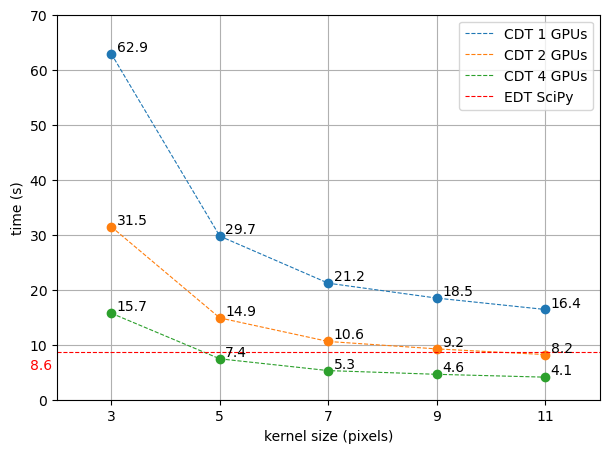

In [5]:
fig, ax = plt.subplots(figsize=(7,5)) 
def plot1(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr[:-1])

    for gpu in [1,2,4]:
        ax.scatter(x,y/gpu)
        ax.plot(x, y/gpu, linestyle='--', linewidth = 0.8, label= f'CDT {gpu} GPUs')

        for i in range(len(x)):
            ax.text(x[i] + 0.1, 
                    y[i]/gpu + 0.5, 
                    f'{y[i]/gpu:.1f}', fontsize=10)
            
    ax.axhline(yarr[-1], color = 'r', linestyle = '--', linewidth = 0.8, label = 'EDT SciPy ')
    ax.text(1.5, yarr[-1] - 3, "{:.1f}".format(yarr[-1]), color="red")
        
    ax.set_xticks(ticks=x)
    ax.set_ylim(0,70)
    ax.set_xlim(2,12)
    ax.grid(which='both')
    ax.grid(which='minor', linestyle = '--', alpha=0.5)

    ax.set_xlabel('kernel size (pixels)')
    ax.set_ylabel('time (s)')
    ax.legend()

    # plt.savefig("fig1.png", format="png", bbox_inches="tight", dpi = 250)

plot1(speed_arr, ax)

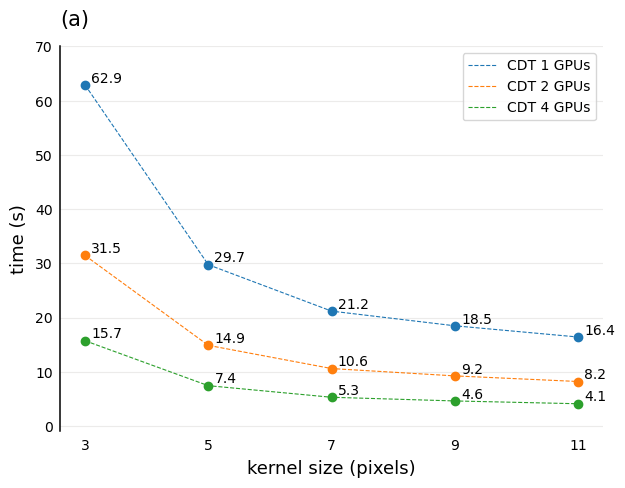

In [21]:
fig, ax = plt.subplots(figsize=(7,5)) 


def plot1(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr[:-1])

    for gpu in [1,2,4]:
        ax.scatter(x,y/gpu)
        ax.plot(x, y/gpu, linestyle='--', linewidth = 0.8, label= f'CDT {gpu} GPUs')

        for i in range(len(x)):
            ax.text(x[i] + 0.1, 
                y[i]/gpu + 0.5, 
                f'{y[i]/gpu:.1f}', fontsize=10)
            
    # ax.axhline(speed_arr[-1], color = 'r', linestyle = '--', linewidth = 0.8, label = 'EDT SciPy ', alpha = 0.5)
    # ax.text(1.5, speed_arr[-1] - 3, "{:.1f}".format(speed_arr[-1]), color="red", fontsize=10)

    ax.set_ylim(-1,70)
    # ax.set_xlim(2,11.5)

    ax.set_xticks(ticks=x)

    # ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)
    ax.xaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)

    ax.set_ylabel('time (s)', fontsize=13, labelpad=5)
    ax.set_xlabel('kernel size (pixels)',fontsize=13, labelpad=5)

    ax.legend()
    ax.set_title('(a)', loc = 'left', pad = 15, fontsize = 15)

plot1(speed_arr, ax)

Text(0.5, 0, 'kernel size (pixels)')

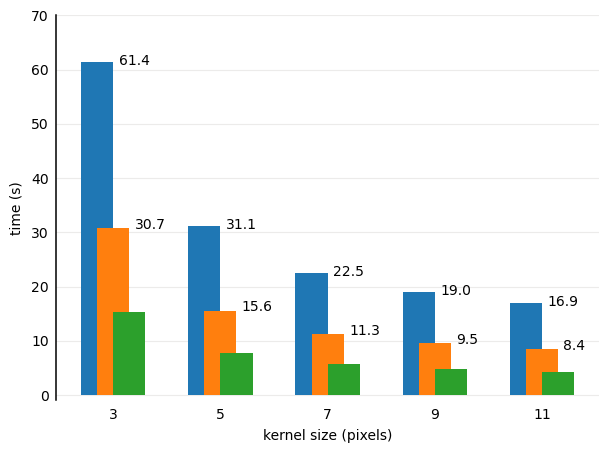

In [149]:
fig, ax = plt.subplots(figsize=(7,5)) 

x = np.array([3, 5, 7, 9, 11])
y = np.array(speed_arr[:-1])


plt.bar(x - 0.3, y, width=0.6)
plt.bar(x, y/2, width=0.6)
plt.bar(x+0.3, y/4, width=0.6)


for i in range(len(x)):
    ax.text(x[i] + 0.1, 
            y[i] - 0.5, 
            f'{y[i]:.1f}', fontsize=10)
    
for i in range(len(x)):
    ax.text(x[i] + 0.4, 
            y[i]/2 - 0.1, 
            f'{y[i]/2:.1f}', fontsize=10)
    
ax.set_ylim(-1,70)
# ax.set_xlim(2,11.5)

ax.set_xticks(ticks=x)

ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.spines[['top','right', 'bottom']].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)
ax.xaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)

ax.set_ylabel('time (s)', fontsize=10, labelpad=5)
ax.set_xlabel('kernel size (pixels)',fontsize=10, labelpad=5)

# ax.legend()

### Precision test

In [ ]:
with open(CONF.LABELS_JSON_PATH) as f:
    lblDict = json.load(f)
    imIDs = lblDict['typ']['scarp']

In [ ]:
total_mae = []
for imID in tqdm(imIDs):
    img_mae = []
    mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
    edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
    
    mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
    
    sdm_scipy = distance_transform_edt(~edges)
    sdm_scipy = sdm_scipy/sdm_scipy.max()

    for k in [3,5,7,9,11]:
        sdm_torch = SDF(mask_tensor, kernel_size = k, h = 0.35)
        sdm_torch = sdm_torch[0][0].detach().cpu().numpy()
        sdm_torch = sdm_torch/sdm_torch.max()

        mae = np.round(np.mean(np.abs(sdm_scipy - sdm_torch)), 3)
        img_mae.append(mae)
    total_mae.append(img_mae)

mae = [np.mean(list(x)) for x in zip(*total_mae)]

100%|██████████| 771/771 [02:29<00:00,  5.17it/s]


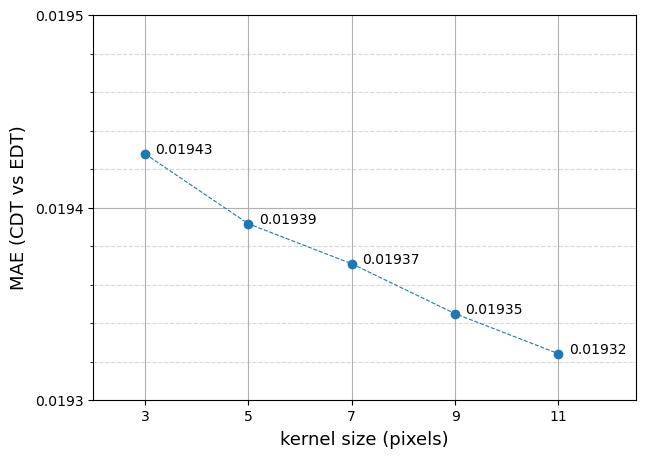

In [19]:
fig, ax = plt.subplots(figsize=(7,5))


def plot2(yarr, ax):

    x = [3, 5, 7, 9, 11]
    y = np.array(yarr)

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x)):
        ax.text(x[i] + 0.2, 
                y[i], 
                f'{y[i]:.5f}', fontsize=10)
        
    ax.set_xticks(ticks=x)
    ax.set_yticks(ticks= [0.0193, 0.0194, .0195])
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xlim(2,12.5)

    ax.grid(which='both')
    ax.grid(which='minor', linestyle = '--', alpha=0.5)
    ax.set_xlabel('kernel size (pixels)', fontsize=13, labelpad=5)
    ax.set_ylabel('MAE (CDT vs EDT)', fontsize=13, labelpad=5)

    # plt.savefig("fig2.png", format="png", bbox_inches="tight", dpi = 250)

plot2(mae, ax)

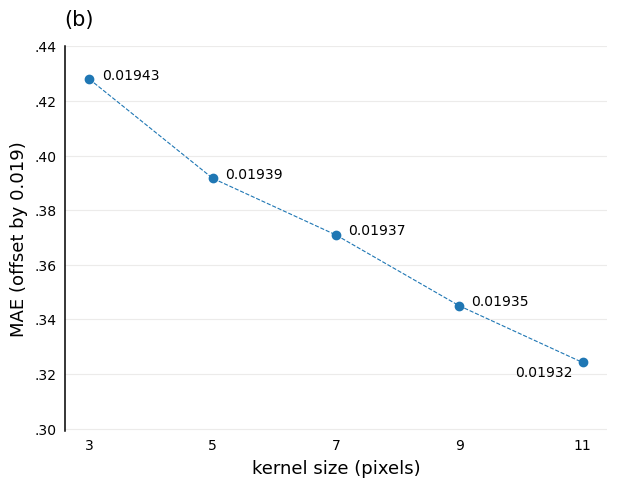

In [22]:
fig, ax = plt.subplots(figsize=(7,5))

def plot2(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr)

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x) - 1):
        ax.text(x[i] + 0.2, 
                y[i], 
                f'{y[i]:.5f}', fontsize=10)
    ax.text(x[4] - 1.1, y[4] - 0.000005, f'{y[4]:.5f}', fontsize=10)


    ax.set_ylim(.019299,.01944)
    # ax.set_xlim(2,12)

    ax.set_xticks(ticks=x)
    ax.set_yticks(ticks= [.01930, .01932, .01934, .01936, .01938, .0194, .01942, .01944])
    ax.set_yticklabels(['.30', '.32', '.34', '.36', '.38', '.40', '.42', '.44'])

    # ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)
    ax.xaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)

    ax.set_ylabel('MAE (offset by 0.019)', fontsize=13, labelpad=5)
    ax.set_xlabel('kernel size (pixels)',fontsize=13, labelpad=5)
    ax.set_title('(b)', loc = 'left', pad = 15, fontsize = 15)

plot2(mae, ax)

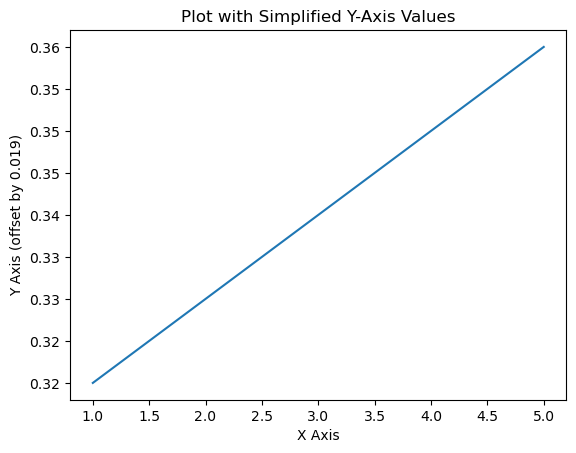

In [202]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Sample data with small y values
x = [1, 2, 3, 4, 5]
y = [0.01932, 0.01933, 0.01934, 0.01935, 0.01936]

fig, ax = plt.subplots()
ax.plot(x, y)

# Define the base value for the y-axis offset
base_value = 0.019  # use the main component for offset

# Custom formatter to display only the significant part
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, _: f"{(val - base_value) * 1000:.2f}"))

# Add a y-axis label indicating the offset
ax.set_ylabel(f"Y Axis (offset by {base_value})")

plt.xlabel("X Axis")
plt.title("Plot with Simplified Y-Axis Values")

plt.show()

100%|██████████| 10/10 [00:00<00:00, 14.11it/s]


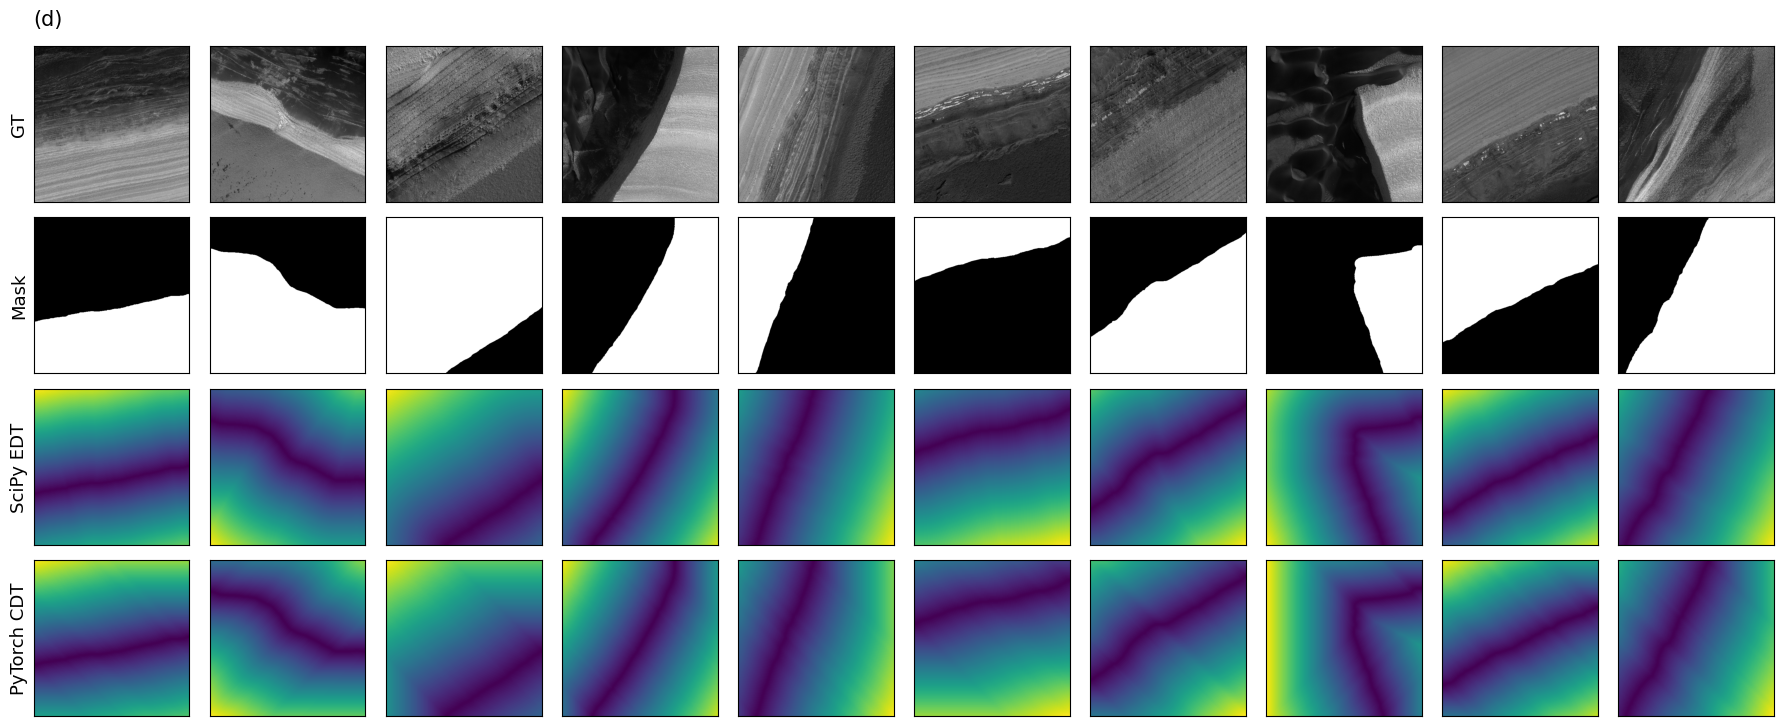

In [17]:
# with open(CONF.IDX_FILE) as f:
#     imIDs = f.read().splitlines()
# import random

# with open(CONF.LABELS_JSON_PATH) as f:
#     lblDict = json.load(f)
#     imIDs = lblDict['typ']['scarp']

num_imgs = 10
fig, ax = plt.subplots(4, num_imgs, figsize=(18,7))

def plot4(fig, ax):
    with open(CONF.LABELS_JSON_PATH) as f:
        lblDict = json.load(f)
        imIDs = lblDict['typ']['scarp']

    imIDs = np.random.choice(imIDs, num_imgs)
    for i,imID in enumerate(tqdm(imIDs)):
        mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        img = cv2.imread(f'{CONF.IMAGE_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
        
        mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
        
        sdm_scipy = distance_transform_edt(~edges)
        sdm_scipy = sdm_scipy/sdm_scipy.max()

        sdm_torch = SDF(mask_tensor, kernel_size = 7, h = 0.35)
        sdm_torch = sdm_torch[0][0].detach().cpu().numpy()
        sdm_torch = sdm_torch/sdm_torch.max()

        ax1, ax2, ax3, ax4 = ax[0], ax[1], ax[2], ax[3]

        ax1[i].imshow(img, cmap = 'gray')
        ax1[i].set_xticks([])
        ax1[i].set_yticks([])

        ax2[i].imshow(mask, cmap = 'gray')
        ax2[i].set_xticks([])
        ax2[i].set_yticks([])

        ax3[i].imshow(sdm_scipy, cmap = 'viridis')
        ax3[i].set_xticks([])
        ax3[i].set_yticks([])
        
        ax4[i].imshow(sdm_torch, cmap = 'viridis')
        ax4[i].set_xticks([])
        ax4[i].set_yticks([])
        

    ax1[0].set_ylabel('GT', fontsize = 13)
    ax2[0].set_ylabel('Mask', fontsize = 13)
    ax3[0].set_ylabel('SciPy EDT', fontsize = 13)
    ax4[0].set_ylabel('PyTorch CDT', fontsize = 13)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    ax1[0].set_title('(d)', loc = 'left', pad = 15, fontsize = 15)
    plt.savefig("fig2.png", format="png", bbox_inches="tight")


plot4(fig, ax)

### Speed Test

In [16]:
speed_arr2 = []
with open(CONF.LABELS_JSON_FILE) as f:
    lblDict = json.load(f)
    imIDs = lblDict['typ']['scarp']

In [17]:
# SciPy
for j in range(1,11):
    _imIDs = imIDs*j
    t1 = time.time()
    for imID in tqdm(_imIDs):
        mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
        sdm_scipy = distance_transform_edt(~edges)

    t2 = time.time()
    dt = t2 - t1
    speed_arr2.append(np.round(dt, 2))
    print(f'SciPy EDT: {dt}s')

100%|██████████| 771/771 [00:08<00:00, 88.70it/s]


SciPy EDT: 8.69248080253601s


100%|██████████| 1542/1542 [00:17<00:00, 88.88it/s]


SciPy EDT: 17.348284006118774s


100%|██████████| 2313/2313 [00:26<00:00, 88.77it/s]


SciPy EDT: 26.05627131462097s


100%|██████████| 3084/3084 [00:34<00:00, 88.88it/s]


SciPy EDT: 34.69924259185791s


100%|██████████| 3855/3855 [00:43<00:00, 88.79it/s]


SciPy EDT: 43.415931224823s


100%|██████████| 4626/4626 [00:52<00:00, 88.70it/s]


SciPy EDT: 52.155555963516235s


100%|██████████| 5397/5397 [01:00<00:00, 88.67it/s]


SciPy EDT: 60.873589754104614s


100%|██████████| 6168/6168 [01:09<00:00, 88.78it/s]


SciPy EDT: 69.47555017471313s


100%|██████████| 6939/6939 [01:18<00:00, 88.78it/s]


SciPy EDT: 78.15835499763489s


100%|██████████| 7710/7710 [01:26<00:00, 88.72it/s]

SciPy EDT: 86.90791392326355s


In [88]:
# PyTorch CPU
t1 = time.time()

for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
    mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0)
    sdm_torch = SDF(mask_tensor, kernel_size = 7, h = 0.35)

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch CPU: {dt}s')

100%|██████████| 771/771 [02:32<00:00,  5.04it/s]

PyTorch CPU: 152.83281302452087s


In [ ]:
# PyTorch CPU batched
t1 = time.time()

mask_batch = []
imID_batch = []
for i, imID in enumerate(tqdm(imIDs), start=1):
    mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
    mask_batch.append(mask) 
    imID_batch.append(imID)
    if i%16 == 0 or i == len(imIDs):
        mask_batch = np.stack(mask_batch, axis=0)
        mask_batch_tensor = torch.tensor(mask_batch).to(torch.float32).unsqueeze(1)

        SDMs = SDF(mask_batch_tensor, kernel_size = 7)

        mask_batch = []
        imID_batch = []

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch CPU batched: {dt}s')

100%|██████████| 771/771 [02:26<00:00,  5.27it/s]

PyTorch CPU batched: 146.35313510894775s


In [92]:
# PyTorch GPU
t1 = time.time()

for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
    mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
    sdm_torch = SDF(mask_tensor, kernel_size = 7, h = 0.35)

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch GPU: {dt}s')

100%|██████████| 771/771 [00:20<00:00, 37.22it/s]

PyTorch GPU: 20.716524124145508s


In [15]:
# PyTorch GPU batched
# t1 = time.time()
mask_batch = []
imID_batch = []
for j in range(1,11):
    _imIDs = imIDs*j
    t1 = time.time()
    for i, imID in enumerate(tqdm(_imIDs), start=1):
        mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        mask_batch.append(mask) 
        imID_batch.append(imID)
        if i%16 == 0 or i == len(imIDs):
            mask_batch = np.stack(mask_batch, axis=0)
            mask_batch_tensor = torch.tensor(mask_batch).to(torch.float32).unsqueeze(1)
            mask_batch_tensor = mask_batch_tensor.to('cuda:0')

            SDMs = SDF(mask_batch_tensor, kernel_size = 7)

            mask_batch = []
            imID_batch = []
    t2 = time.time()
    dt = t2 - t1
    speed_arr2.append(np.round(dt, 2))
    print(f'PyTorch GPU batch: {dt}s')

100%|██████████| 771/771 [00:04<00:00, 154.64it/s]


PyTorch GPU batch: 4.9882378578186035s


100%|██████████| 1542/1542 [00:09<00:00, 162.65it/s]


PyTorch GPU batch: 9.486800909042358s


100%|██████████| 2313/2313 [00:14<00:00, 164.06it/s]


PyTorch GPU batch: 14.105369806289673s


100%|██████████| 3084/3084 [00:18<00:00, 164.11it/s]


PyTorch GPU batch: 18.793680906295776s


100%|██████████| 3855/3855 [00:23<00:00, 164.51it/s]


PyTorch GPU batch: 23.440268516540527s


100%|██████████| 4626/4626 [00:28<00:00, 163.84it/s]


PyTorch GPU batch: 28.237656593322754s


100%|██████████| 5397/5397 [00:32<00:00, 163.56it/s]


PyTorch GPU batch: 32.997220516204834s


100%|██████████| 6168/6168 [00:37<00:00, 164.69it/s]


PyTorch GPU batch: 37.455841302871704s


100%|██████████| 6939/6939 [00:42<00:00, 165.21it/s]


PyTorch GPU batch: 42.00382423400879s


100%|██████████| 7710/7710 [00:46<00:00, 165.48it/s]

PyTorch GPU batch: 46.593865633010864s


In [99]:
speed_arr2.append(np.round(speed_arr2[-1]/4, 1))

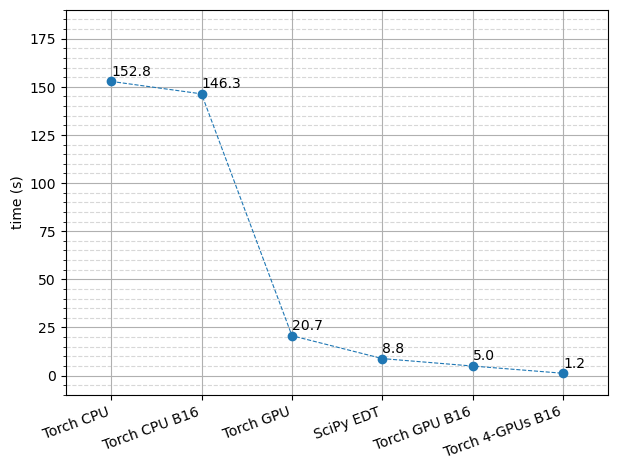

In [103]:
fig, ax = plt.subplots(figsize=(7,5))

def plot3(ax):
    x = ['Torch CPU', 'Torch CPU B16', 'Torch GPU', 'SciPy EDT', 'Torch GPU B16', 'Torch 4-GPUs B16']
    x_i = [0,1,2,3,4,5]
    y = [152.83, 146.35, 20.72, 8.83, 4.95, 1.2]

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)
    plt.xticks(rotation=20, ha='right')

    for i in range(len(x)):
        ax.text(x_i[i], y[i] + 3, f'{y[i]:.1f}', fontsize=10)
        

    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(-10,190)

    ax.grid(which='both')
    ax.grid(which='minor',linestyle = '--', alpha=0.5)
    ax.set_ylabel('time (s)')

plot3(ax)

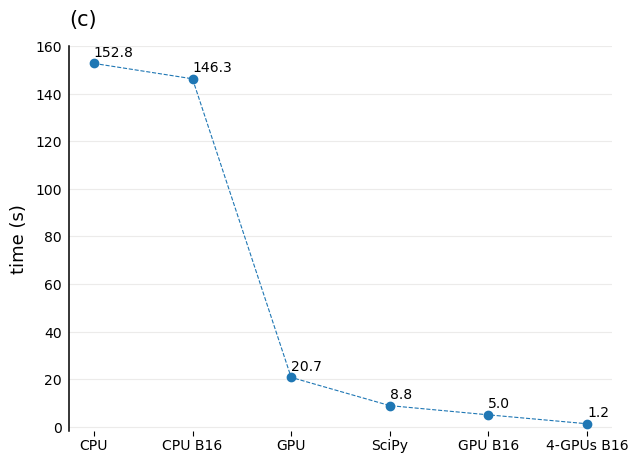

In [18]:
fig, ax = plt.subplots(figsize=(7,5))

def plot3(ax):
    x = ['CPU', 'CPU B16', 'GPU', 'SciPy', 'GPU B16', '4-GPUs B16']
    x_i = [0,1,2,3,4,5]
    y = [152.83, 146.35, 20.72, 8.83, 4.95, 1.2]

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x)):
        ax.text(x_i[i], y[i] + 3, f'{y[i]:.1f}', fontsize=10)

    ax.set_ylim(-2,160)
    # ax.set_xlim(2,12)

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)
    ax.xaxis.set_tick_params(pad=2, labelsize=10)

    ax.set_ylabel('time (s)', fontsize=13, labelpad=5)
    ax.set_title('(c)', loc = 'left', pad = 15, fontsize = 15)

plot3(ax)

In [185]:
165/7

23.571428571428573

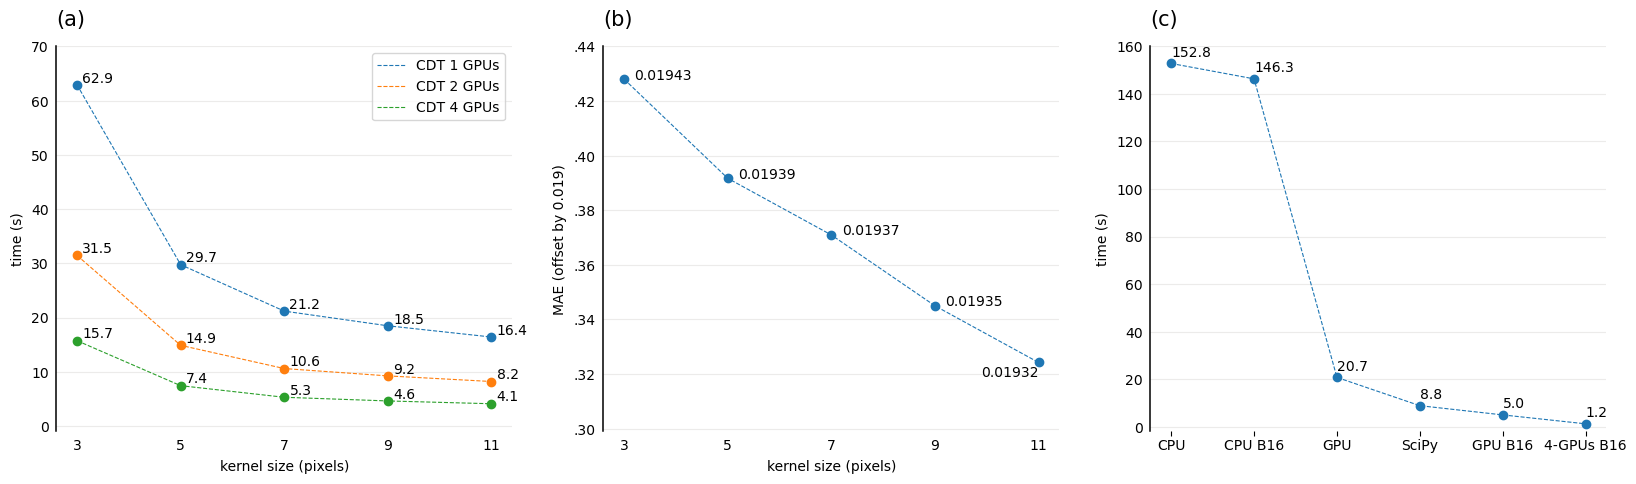

In [13]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
plot1(speed_arr, ax[0])
plot2(mae, ax[1])
plot3(ax[2])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)
# plot4([ax[3], ax[4], ax[5], ax[6]])
# plt.savefig('fig1.png')
plt.savefig("fig1.png", format="png", bbox_inches="tight", dpi = 250)